In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Subset

In [2]:
# Параметры
latent_dim = 32
input_shape = 784  # 28x28
batch_size = 128
epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_string = 'VYL9'

# Количество классов для цифр и букв
num_digit_classes = 10  # 0-9
num_letter_classes = 26  # A-Z

In [52]:
# ======================
# Conditional GAN для цифр
# ======================

class DigitGenerator(nn.Module):
    def __init__(self):
        super(DigitGenerator, self).__init__()
        
        self.label_emb = nn.Embedding(num_digit_classes, num_digit_classes)
        
        self.model = nn.Sequential(
            nn.Linear(latent_dim + num_digit_classes, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, input_shape),
            nn.Tanh()
        )
    
    def forward(self, noise, labels):
        # Конкатенируем шум и метку класса
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), 1, 28, 28)
        return img

class DigitDiscriminator(nn.Module):
    def __init__(self):
        super(DigitDiscriminator, self).__init__()
        
        self.label_emb = nn.Embedding(num_digit_classes, num_digit_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_shape + num_digit_classes, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, img, labels):
        # Выравниваем изображение и добавляем метку класса
        img_flat = img.view(img.size(0), -1)
        d_in = torch.cat((img_flat, self.label_emb(labels)), -1)
        validity = self.model(d_in)
        return validity

In [53]:
# ======================
# Conditional GAN для букв
# ======================

class LetterGenerator(nn.Module):
    def __init__(self):
        super(LetterGenerator, self).__init__()
        
        self.label_emb = nn.Embedding(num_letter_classes, num_letter_classes)
        
        self.model = nn.Sequential(
            nn.Linear(latent_dim + num_letter_classes, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 2048),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(2048, input_shape),
            nn.Tanh()
        )
    
    def forward(self, noise, labels):
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), 1, 28, 28)
        return img

class LetterDiscriminator(nn.Module):
    def __init__(self):
        super(LetterDiscriminator, self).__init__()
        
        self.label_emb = nn.Embedding(num_letter_classes, num_letter_classes)
        
        self.model = nn.Sequential(
            nn.Linear(input_shape + num_letter_classes, 2048),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(2048, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
    
    def forward(self, img, labels):
        img_flat = img.view(img.size(0), -1)
        d_in = torch.cat((img_flat, self.label_emb(labels)), -1)
        validity = self.model(d_in)
        return validity

In [5]:
# Функция потерь (Binary Cross-Entropy Loss)
adversarial_loss = torch.nn.BCELoss()

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.permute(1, 0, 2)),  # Поворот на 90 градусов против часовой
    transforms.Lambda(lambda x: torch.flip(x, [1])),  # Зеркальное отражение по вертикали
    transforms.Normalize([0.5], [0.5])  # Нормализация для GAN (это обязательно)
])

# Загрузка данных (как в исходном коде)
digits_dataset = torchvision.datasets.EMNIST(
    root='./data', train=True, download=True, transform=transform, split='digits'
)

full_byclass_dataset = torchvision.datasets.EMNIST(
    root='./data', train=True, download=True, transform=transform, split='byclass'
)

classes = full_byclass_dataset.classes
capital_label_indices = [i for i, c in enumerate(classes) if c.isupper() and c.isalpha()]
capital_indices = [i for i, (_, label) in enumerate(full_byclass_dataset) if label in capital_label_indices]
letters_dataset = Subset(full_byclass_dataset, capital_indices)

digit_loader = DataLoader(digits_dataset, batch_size=batch_size, shuffle=True)
letter_loader = DataLoader(letters_dataset, batch_size=batch_size, shuffle=True)

In [8]:
# Инициализация моделей
digit_generator = DigitGenerator().to(device)
digit_discriminator = DigitDiscriminator().to(device)
letter_generator = LetterGenerator().to(device)
letter_discriminator = LetterDiscriminator().to(device)

# Оптимизаторы
optimizer_G_digits = optim.Adam(digit_generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_digits = optim.Adam(digit_discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_G_letters = optim.Adam(letter_generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_letters = optim.Adam(letter_discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [9]:
# Обучение для цифр
for epoch in range(epochs):
    for i, (imgs, labels) in enumerate(digit_loader):
        batch_size = imgs.shape[0]
        
        # Adversarial ground truths
        valid = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)
        
        # Configure input
        real_imgs = imgs.to(device)
        labels = labels.to(device)
        
        # ======================
        #  Train Generator
        # ======================
        optimizer_G_digits.zero_grad()
        
        # Sample noise and labels
        z = torch.randn(batch_size, latent_dim).to(device)
        gen_labels = torch.randint(0, num_digit_classes, (batch_size,)).to(device)
        
        # Генерация изображений
        gen_imgs = digit_generator(z, gen_labels)
        
        # Loss measures generator's ability to fool the discriminator
        validity = digit_discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        optimizer_G_digits.step()
        
        # ======================
        #  Обучение дискриминатора
        # ======================
        optimizer_D_digits.zero_grad()
        
        # Потери на настоящих изображениях
        real_pred = digit_discriminator(real_imgs, labels)
        d_real_loss = adversarial_loss(real_pred, valid)
        
        # Потери на фейковых изображениях
        fake_pred = digit_discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = adversarial_loss(fake_pred, fake)
        
        # Общие потери
        d_loss = (d_real_loss + d_fake_loss) / 2
        
        d_loss.backward()
        optimizer_D_digits.step()
        
    print(f"[Digits Epoch {epoch + 1}/{epochs}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")


[Digits Epoch 1/50] [D loss: 0.0624] [G loss: 3.4120]
[Digits Epoch 2/50] [D loss: 0.0312] [G loss: 4.7652]
[Digits Epoch 3/50] [D loss: 0.8818] [G loss: 9.7431]
[Digits Epoch 4/50] [D loss: 0.1886] [G loss: 3.9954]
[Digits Epoch 5/50] [D loss: 0.2549] [G loss: 2.3581]
[Digits Epoch 6/50] [D loss: 0.3463] [G loss: 1.4118]
[Digits Epoch 7/50] [D loss: 0.2387] [G loss: 2.1793]
[Digits Epoch 8/50] [D loss: 0.2049] [G loss: 2.2029]
[Digits Epoch 9/50] [D loss: 0.2445] [G loss: 1.9564]
[Digits Epoch 10/50] [D loss: 0.3595] [G loss: 2.3753]
[Digits Epoch 11/50] [D loss: 0.2845] [G loss: 1.7810]
[Digits Epoch 12/50] [D loss: 0.2601] [G loss: 2.8548]
[Digits Epoch 13/50] [D loss: 0.2798] [G loss: 1.7656]
[Digits Epoch 14/50] [D loss: 0.2856] [G loss: 1.9427]
[Digits Epoch 15/50] [D loss: 0.3002] [G loss: 1.5478]
[Digits Epoch 16/50] [D loss: 0.2891] [G loss: 1.5684]
[Digits Epoch 17/50] [D loss: 0.3459] [G loss: 3.0325]
[Digits Epoch 18/50] [D loss: 0.3495] [G loss: 1.9674]
[Digits Epoch 19/50

In [10]:
# Обучение для букв
for epoch in range(epochs):
    for i, (imgs, labels) in enumerate(letter_loader):
        batch_size = imgs.shape[0]
        
        valid = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)
        
        real_imgs = imgs.to(device)
        labels = (labels - 10).to(device)  # Приводим к диапазону 0-25
        
        # Обучение генератора
        optimizer_G_letters.zero_grad()
        
        z = torch.randn(batch_size, latent_dim).to(device)
        gen_labels = torch.randint(0, num_letter_classes, (batch_size,)).to(device)
        
        gen_imgs = letter_generator(z, gen_labels)
        validity = letter_discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        optimizer_G_letters.step()
        
        # Обучение дискриминатора
        optimizer_D_letters.zero_grad()
        
        real_pred = letter_discriminator(real_imgs, labels)
        d_real_loss = adversarial_loss(real_pred, valid)
        
        fake_pred = letter_discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = adversarial_loss(fake_pred, fake)
        
        d_loss = (d_real_loss + d_fake_loss) / 2
        
        d_loss.backward()
        optimizer_D_letters.step()
        
    print(f"[Letters Epoch {epoch + 1}/{epochs}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

[Letters Epoch 1/50] [D loss: 0.2010] [G loss: 2.6427]
[Letters Epoch 2/50] [D loss: 0.1906] [G loss: 1.8882]
[Letters Epoch 3/50] [D loss: 0.3615] [G loss: 2.6034]
[Letters Epoch 4/50] [D loss: 0.4042] [G loss: 2.1480]
[Letters Epoch 5/50] [D loss: 0.4341] [G loss: 1.5962]
[Letters Epoch 6/50] [D loss: 0.4315] [G loss: 1.2780]
[Letters Epoch 7/50] [D loss: 0.4574] [G loss: 1.3150]
[Letters Epoch 8/50] [D loss: 0.5958] [G loss: 1.0907]
[Letters Epoch 9/50] [D loss: 0.5469] [G loss: 0.8791]
[Letters Epoch 10/50] [D loss: 0.6242] [G loss: 0.9686]
[Letters Epoch 11/50] [D loss: 0.5693] [G loss: 1.0958]
[Letters Epoch 12/50] [D loss: 0.5610] [G loss: 0.9504]
[Letters Epoch 13/50] [D loss: 0.6758] [G loss: 0.9348]
[Letters Epoch 14/50] [D loss: 0.6609] [G loss: 1.0248]
[Letters Epoch 15/50] [D loss: 0.6002] [G loss: 0.9769]
[Letters Epoch 16/50] [D loss: 0.6465] [G loss: 0.8016]
[Letters Epoch 17/50] [D loss: 0.6309] [G loss: 0.9230]
[Letters Epoch 18/50] [D loss: 0.5806] [G loss: 0.9887]
[

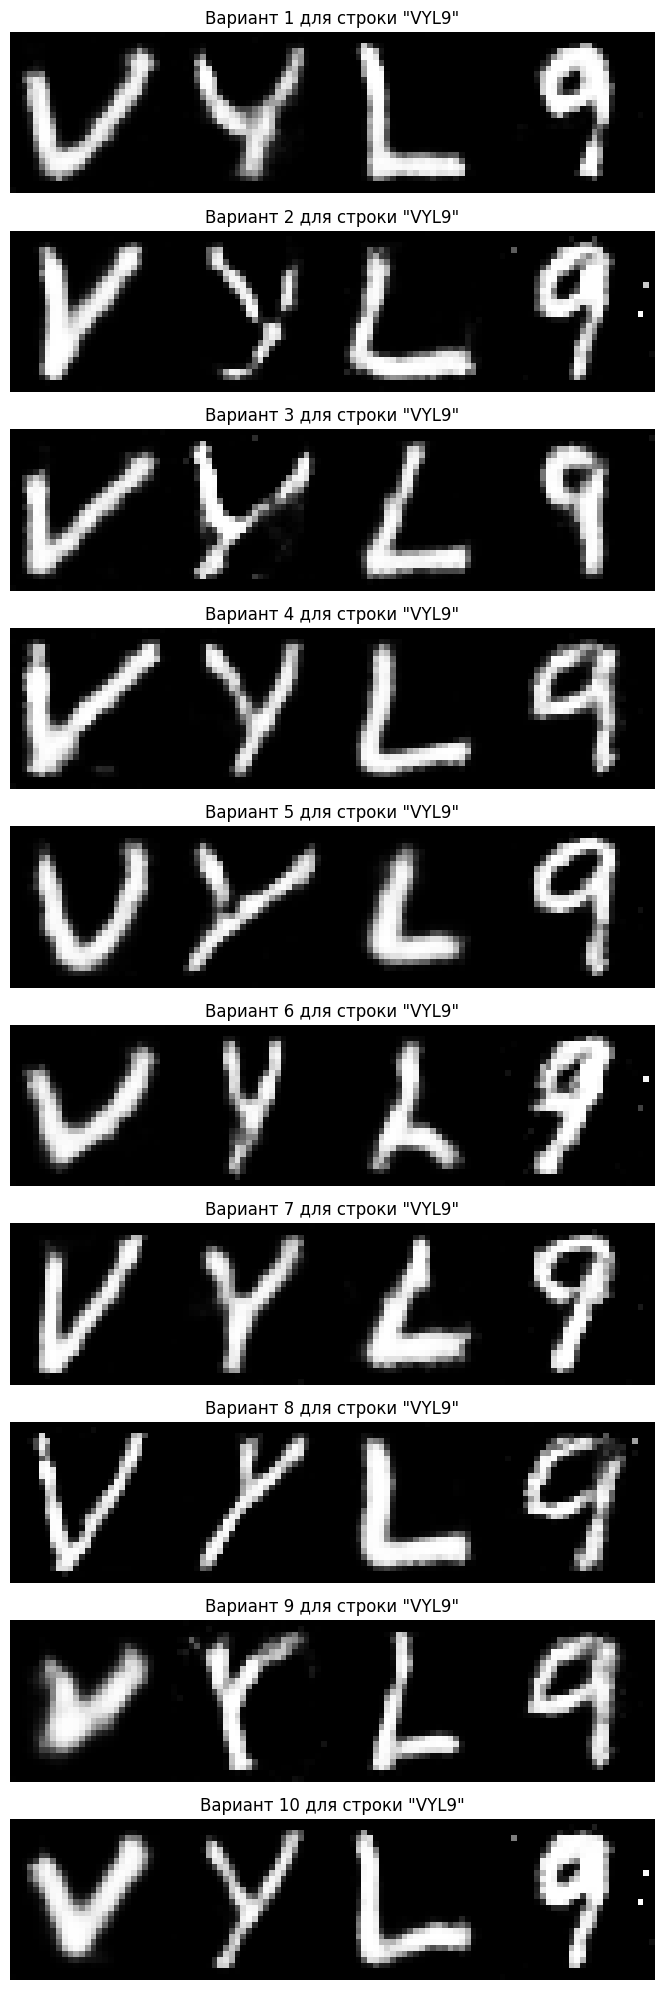

In [51]:
# ======================
# Генерация символов по заданной строке
# ======================

def generate_string_conditional(test_string, num_generations=10):
    digit_generator.eval()
    letter_generator.eval()
    
    generated_strings = []
    
    with torch.no_grad():
        for _ in range(num_generations):
            generated_parts = []
            
            for char in test_string:
                if char.isdigit():
                    # Генерация цифры
                    label = int(char)
                    z = torch.randn(1, latent_dim).to(device)
                    generated = digit_generator(z, torch.tensor([label]).to(device))
                else:
                    # Генерация буквы
                    char_upper = char.upper()
                    label = ord(char_upper) - ord('A')
                    z = torch.randn(1, latent_dim).to(device)
                    generated = letter_generator(z, torch.tensor([label]).to(device))
                
                # Поворот изображения на 270 градусов против часовой стрелки и зеркальное отражение
                generated = torch.rot90(generated, k=-3, dims=[2, 3])
                generated = torch.flip(generated, [2])
                
                generated_parts.append(generated)
            
            generated_string = torch.cat(generated_parts, dim=3)
            generated_strings.append(generated_string.cpu())
    
    return generated_strings

# Визуализация результатов
def visualize_generated_strings(generated_strings, test_string):
    plt.figure(figsize=(15, 2 * len(generated_strings)))
    
    for i, string_img in enumerate(generated_strings):
        plt.subplot(len(generated_strings), 1, i+1)
        plt.imshow(string_img.squeeze(), cmap='gray')
        plt.title(f'Вариант {i+1} для строки "{test_string}"')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Генерация и визуализация
generated_strings = generate_string_conditional(test_string, num_generations=10)
visualize_generated_strings(generated_strings, test_string)